In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.timeseries import LombScargle
from scipy import interpolate
from scipy.optimize import curve_fit

from constants import DATA_DIR, ASTEROIDS_DIR
from src.damit_connector import AsteroidDownloader
from src.model import Asteroid, Lightcurve
from src.model.enums import EnumSortOptions
from src.plotter import LightcurvePlotter

sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (14, 6)

In [2]:
ASTEROIDS_DF = pd.read_csv(DATA_DIR / "asteroids.csv", index_col=0)
ASTEROIDS_DF = ASTEROIDS_DF.dropna(subset=["number"])
ASTEROIDS_DF["number"] = ASTEROIDS_DF["number"].astype(int)
ASTEROIDS_DF

,number,name,designation,comment,created,modified
id,,,,,,
3414,1,Ceres,NaN,albedo effects,2021-11-18 10:13:38,2021-11-18 10:14:01
101,2,Pallas,NaN,NaN,NaN,2019-05-31 11:22:28
102,3,Juno,NaN,NaN,NaN,2010-04-15 15:54:09
3415,4,Vesta,NaN,albedo effects,2021-11-19 11:18:10,2021-11-19 11:27:06
103,5,Astraea,NaN,NaN,NaN,2010-04-15 15:54:09
...,...,...,...,...,...,...
7103,353971,NaN,NaN,NaN,2023-05-23 07:51:09,2023-05-23 07:51:09
7110,354510,NaN,NaN,NaN,2023-05-23 07:51:09,2023-05-23 07:51:09
7194,362935,NaN,NaN,NaN,2023-05-23 07:51:13,2023-05-23 07:51:13


In [3]:
downloader = AsteroidDownloader(ASTEROIDS_DF)

In [4]:
# downloader.query_asteroid("9")

In [5]:
C_G_S = "\033[1;32m"
C_Y_S = "\033[1;33m"
C_E = "\033[0m"


In [6]:
PERIOD_FILE = "period.txt"

In [7]:
AVAILABLE_ASTEROIDS = {}
for directory in ASTEROIDS_DIR.iterdir():
    if not directory.is_dir():
        continue

    asteroid_name = directory.name.split("_")[0]
    work_name = directory.name

    res = ASTEROIDS_DF.query(f"name == '{asteroid_name}'")
    if len(res) != 1:
        raise ValueError(f"Found multiple asteroids with name {asteroid_name} (work name: {work_name})")

    (asteroid_num,) = res["number"]

    if not (directory / PERIOD_FILE).exists():
        raise FileNotFoundError(f"Missing {PERIOD_FILE} for {work_name}")
    
    with open(directory / PERIOD_FILE, "r") as f:
        period = float(f.read().strip())
    
    AVAILABLE_ASTEROIDS[work_name] = {"id": asteroid_num, "name": asteroid_name, "period": period}

AVAILABLE_ASTEROIDS = {k: AVAILABLE_ASTEROIDS[k] for k in sorted(AVAILABLE_ASTEROIDS)}


In [8]:
AVAILABLE_ASTEROIDS

{'Ceres': {'id': 1, 'name': 'Ceres', 'period': 9.074173},
 'Eros': {'id': 433, 'name': 'Eros', 'period': 5.27025528},
 'Eunomia': {'id': 15, 'name': 'Eunomia', 'period': 6.082754},
 'Flora': {'id': 8, 'name': 'Flora', 'period': 12.86667},
 'Interamnia': {'id': 704, 'name': 'Interamnia', 'period': 8.712337},
 'Iris': {'id': 7, 'name': 'Iris', 'period': 7.138844},
 'Metis': {'id': 9, 'name': 'Metis', 'period': 5.079177},
 'Pallas': {'id': 2, 'name': 'Pallas', 'period': 7.81322},
 'Sylvia': {'id': 87, 'name': 'Sylvia', 'period': 5.183641},
 'Vesta': {'id': 4, 'name': 'Vesta', 'period': 5.342124}}

In [9]:
asteroid_name = "Eunomia"  # Interamnia, Eros, Ceres, Eunomia
chosen_asteroid = AVAILABLE_ASTEROIDS[asteroid_name]
asteroid_id, known_period = chosen_asteroid["id"], chosen_asteroid["period"]

with open(ASTEROIDS_DIR / asteroid_name / "lc.json", "r") as f:
    raw_data = json.load(f)

In [10]:
raw_data[0]

{'LightCurve': {'id': '384',
  'asteroid_id': '108',
  'scale': '0',
  'filter': None,
  'points': '2433504.627269  1.164801e+00    -1.28328143   2.20256616  -0.05387223   -0.52330018   1.53207690  -0.05395223\n2433504.627936  1.172335e+00    -1.28328682   2.20256143  -0.05387366   -0.52329817   1.53208073  -0.05395366\n2433504.635102  1.138287e+00    -1.28334470   2.20251057  -0.05388899   -0.52327650   1.53212187  -0.05396898\n2433504.636144  1.138287e+00    -1.28335312   2.20250317  -0.05389122   -0.52327335   1.53212785  -0.05397121\n2433504.645352  1.051603e+00    -1.28342749   2.20243782  -0.05391092   -0.52324553   1.53218073  -0.05399089\n2433504.649102  1.027666e+00    -1.28345778   2.20241121  -0.05391895   -0.52323420   1.53220227  -0.05399891\n2433504.650144  1.025774e+00    -1.28346620   2.20240381  -0.05392118   -0.52323105   1.53220826  -0.05400114\n2433504.654560  9.823174e-01    -1.28350187   2.20237246  -0.05393063   -0.52321772   1.53223363  -0.05401058\n2433504.6552

In [11]:
asteroid = Asteroid.from_lightcurves(
    id=asteroid_id,
    name=asteroid_name,
    period=known_period,
    data=raw_data
)
asteroid

Asteroid(id=15, name=Eunomia, period=6.082754, lightcurves=109)

In [12]:
asteroid.get_longest_lightcurve(by=EnumSortOptions.PERIOD)

Lightcurve(id=409, period=6.67997h scale=0, points_count=41)

In [13]:
from random import choice

In [14]:
# LightcurvePlotter.plot_lightcurves([
#     asteroid.get_lightcurve(14633),
#     asteroid.get_longest_lightcurve(by=EnumSortOptions.PERIOD),
# ], subplots=True)

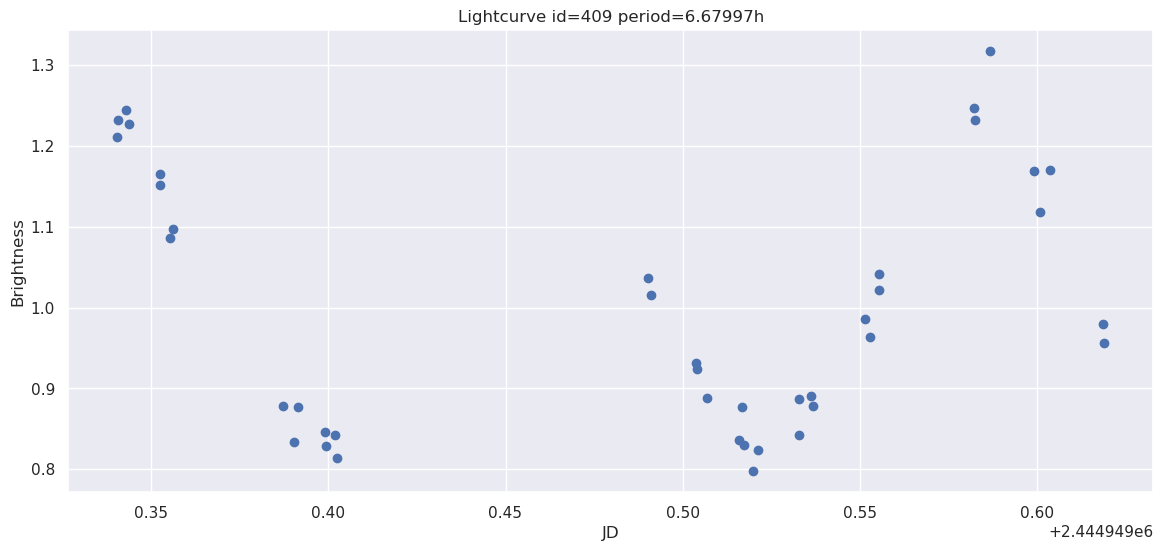

In [15]:
asteroid.get_longest_lightcurve(by=EnumSortOptions.PERIOD).plot()

In [16]:
asteroid.get_longest_lightcurve(by=EnumSortOptions.POINTS)

Lightcurve(id=20253, period=4.97808h scale=0, points_count=447)

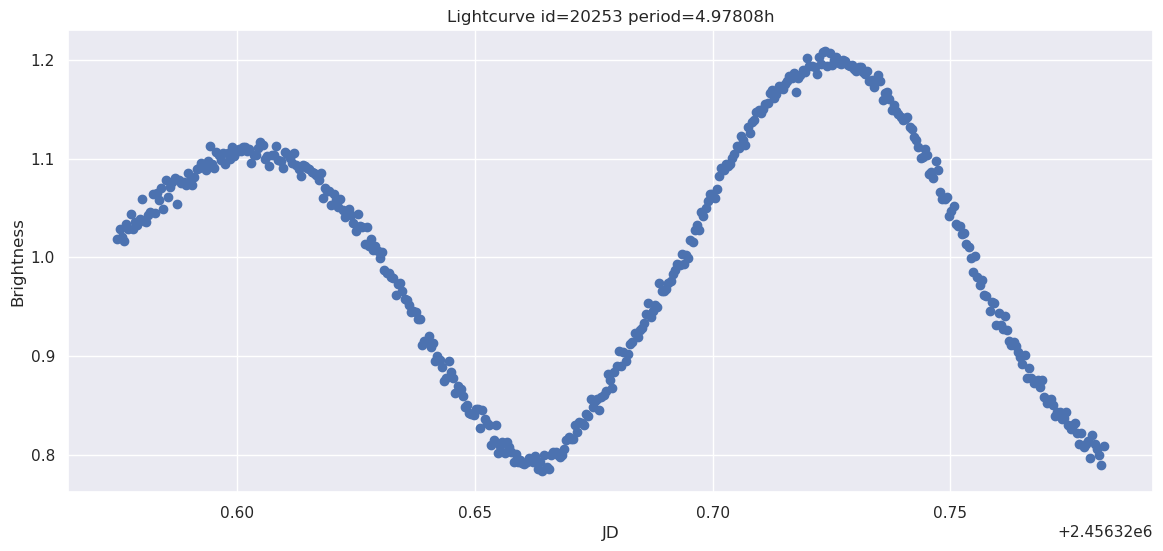

In [17]:
asteroid.get_longest_lightcurve(by=EnumSortOptions.POINTS).plot()

In [18]:
# Splitting long lightcurve into smaller ones - current the case for Sylvia
if False:
    too_long_lc = asteroid.get_lightcurves(by=EnumSortOptions.PERIOD)[0]
    lc_config = {
        "id": too_long_lc.id,
        "scale": too_long_lc.scale,
        "created": too_long_lc.created_at,
        "modified": too_long_lc.updated_at,
    }

    separated_lcs = []
    curr_points = []
    prev_point = None

    THRESHOLD = 10 # days
    for point in too_long_lc.points:
        if prev_point is None:
            prev_point = point
            curr_points.append(point)
            continue

        if point.JD - prev_point.JD > THRESHOLD:
            separated_lcs.append(Lightcurve.model_validate(lc_config | {"points": curr_points, "points_count": len(curr_points)}))
            curr_points = []

        curr_points.append(point)
        prev_point = point


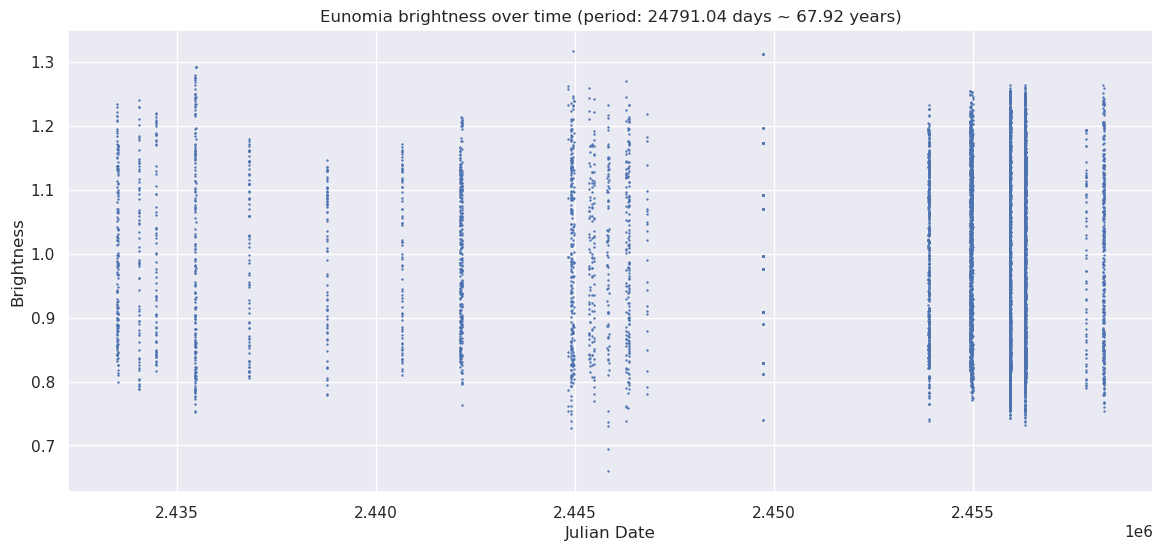

In [19]:
brightness = []
times = []
for lc in asteroid.lightcurves:
    for point in lc.points:
        brightness.append(point.brightness)
        times.append(point.JD)

period = times[-1] - times[0]

plt.scatter(times, brightness, s=0.5)
plt.xlabel("Julian Date")
plt.ylabel("Brightness")
plt.title(f"{asteroid.name} brightness over time (period: {period:.2f} days ~ {period / 365:.2f} years)")
plt.show()


In [20]:
MAX_DIFF_THRESHOLD = 30  # days
bins: list[list[Lightcurve]] = [[]]

curr_bin = 0
bin_start = None
for lc in asteroid.lightcurves:
    if bin_start is None:
        bin_start = lc.first_JD

    if lc.last_JD - bin_start > MAX_DIFF_THRESHOLD:
        curr_bin += 1
        bin_start = lc.first_JD
        bins.append([])

    bins[curr_bin].append(lc)

for ind, _bin in enumerate(bins):
    first_JD = _bin[0].first_JD
    last_JD = _bin[-1].last_JD
    print(f"{ind:2} - {C_Y_S}{len(_bin):2}{C_E} lcs from {first_JD:.2f} to {last_JD:.2f} {C_G_S}({last_JD - first_JD:5.2f} days){C_E}")

 0 -  2 lcs from 2433504.63 to 2433508.77 ( 4.14 days)
 1 -  1 lcs from 2434036.59 to 2434036.84 ( 0.25 days)
 2 -  1 lcs from 2434474.68 to 2434474.85 ( 0.18 days)
 3 -  3 lcs from 2435462.58 to 2435468.70 ( 6.12 days)
 4 -  1 lcs from 2436821.08 to 2436821.34 ( 0.27 days)
 5 -  1 lcs from 2438760.99 to 2438761.27 ( 0.27 days)
 6 -  1 lcs from 2440652.71 to 2440652.97 ( 0.26 days)
 7 -  3 lcs from 2442103.37 to 2442130.40 (27.04 days)
 8 -  5 lcs from 2442149.30 to 2442158.36 ( 9.06 days)
 9 -  1 lcs from 2444822.86 to 2444822.99 ( 0.13 days)
10 -  6 lcs from 2444912.26 to 2444941.00 (28.74 days)
11 -  2 lcs from 2444949.34 to 2444978.93 (29.59 days)
12 -  1 lcs from 2444979.83 to 2444979.97 ( 0.14 days)
13 -  3 lcs from 2445363.86 to 2445388.76 (24.89 days)
14 -  2 lcs from 2445420.67 to 2445421.68 ( 1.01 days)
15 -  2 lcs from 2445475.64 to 2445479.94 ( 4.30 days)
16 -  2 lcs from 2445798.68 to 2445799.69 ( 1.01 days)
17 -  3 lcs from 2445831.84 to 2445858.85 (27.01 days)
18 -  1 lc

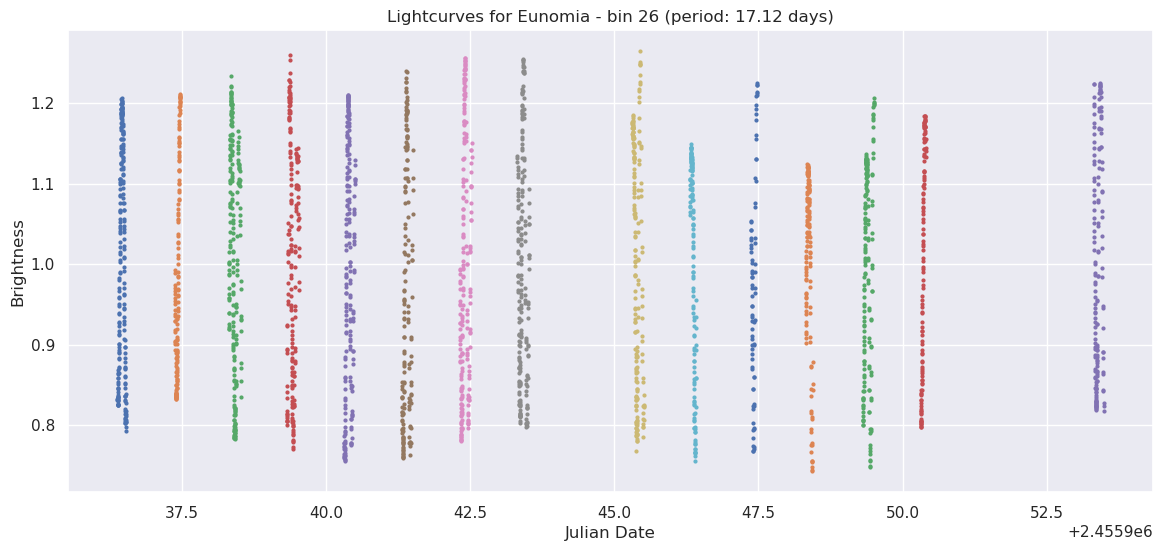

In [21]:
SELECTED_BIN = np.argmax([len(_bin) for _bin in bins])
selected_bin = bins[SELECTED_BIN]
for ind, lc in enumerate(selected_bin):
    times = []
    brightness = []
    for points in lc.points:
        times.append(points.JD)
        brightness.append(points.brightness)

    plt.scatter(times, brightness, s=4)

period = selected_bin[-1].last_JD - selected_bin[0].first_JD
plt.title(f"Lightcurves for {asteroid_name} - bin {SELECTED_BIN} (period: {period:.2f} days)")
plt.xlabel("Julian Date")
plt.ylabel("Brightness")
plt.show()

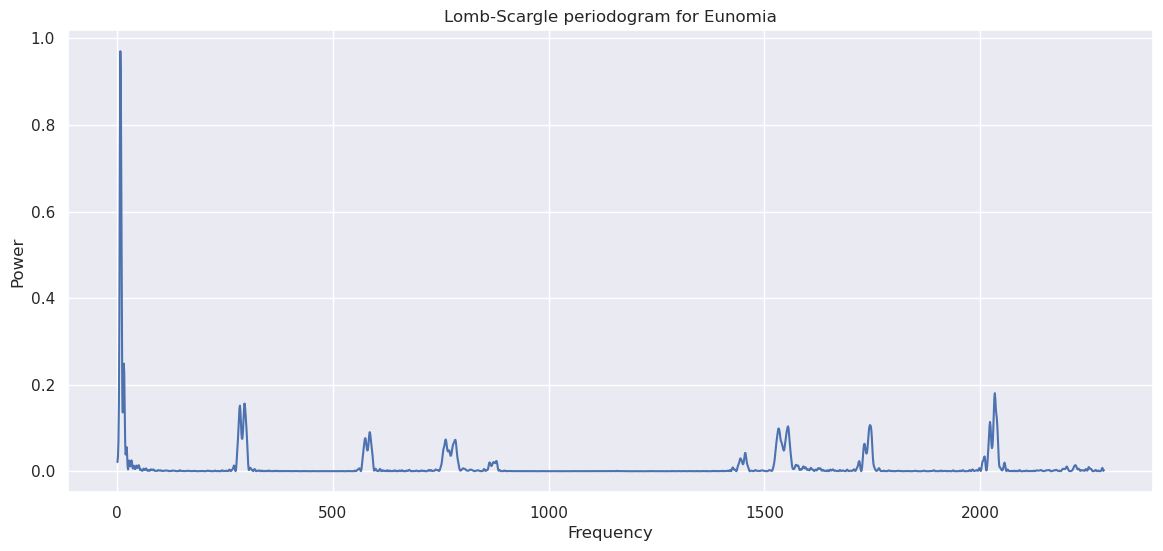

Best frequency: 7.294478085727711
Rotational period: 3.290159997458641h


In [22]:
frequency, power = LombScargle(times, brightness).autopower()
fig = plt.plot(frequency, power)

plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title(f"Lomb-Scargle periodogram for {asteroid_name}")
plt.show()

lomb_freq = frequency[np.argmax(power)]
lomb_period = 24 / lomb_freq

print(f"Best frequency: {lomb_freq}")
print(f"Rotational period: {lomb_period}h")

In [23]:
known_period

6.082754

In [24]:
lomb_period, lomb_period * 2

(3.290159997458641, 6.580319994917282)

In [25]:
def get_phase(time: float, ref_time: float, period: float) -> float:
    return (time - ref_time) * 24 % period / period


In [26]:
def harmonic_model(phase, a0, a1, b1, a2, b2, offset):
    # a1, b1 are the coefficients for the fundamental harmonic (1st harmonic)
    # a2, b2 are the coefficients for the 2nd harmonic
    return (
        a0
        + a1 * np.cos(2 * np.pi * phase)
        + b1 * np.sin(2 * np.pi * phase)
        + a2 * np.cos(4 * np.pi * phase)
        + b2 * np.sin(4 * np.pi * phase)
        + offset
    )


def fourier_model(x, *params):
    n_harmonics = len(params) // 2
    a0 = params[0]
    result = a0
    for i in range(1, n_harmonics):
        a = params[2 * i - 1]
        b = params[2 * i]
        result += a * np.cos(2 * np.pi * i * x) + b * np.sin(2 * np.pi * i * x)
    return result

In [27]:
SELECTED_MODEL = fourier_model


def get_rrs_values(period_range):
    rss_values = []
    for curr_period in period_range:
        # print(f"Trying period: {curr_period:.6f}h")

        phases = []
        brightness = []
        ref_JD = None
        for ind, lc in enumerate(selected_bin):
            if ref_JD is None:
                ref_JD = lc.first_JD

            for point in lc.points:
                phase = get_phase(point.JD, ref_JD, curr_period)

                phases.append(phase)
                brightness.append(point.brightness)

        sorted_indices = np.argsort(phases)
        phases = np.array(phases)[sorted_indices]
        brightness = np.array(brightness)[sorted_indices]

        n_harmonics = 4  # Number of harmonics to include in the model
        initial_guess = [1.0] * (2 * n_harmonics + 1)  # Initial guess for the parameters
        popt, pcov = curve_fit(SELECTED_MODEL, phases, brightness, p0=initial_guess, maxfev=10000)
        predicted_brightness = SELECTED_MODEL(phases, *popt)
        # popt, _ = curve_fit(harmonic_model, phases, brightness)

        # plt.scatter(phases, brightness, s=8, label=f"Lightcurve {lc.id}")
        # plt.plot(phases, predicted_brightness, label="Fit", color="orange")
        # plt.title(f"Phased lightcurves for {asteroid_name} - bin {SELECTED_BIN}")
        # plt.xlabel("Phase")
        # plt.ylabel("Brightness")
        # plt.legend()
        # plt.show()

        residuals = brightness - predicted_brightness
        rss = np.sum(residuals**2)

        rss_values.append(rss)

    return rss_values

/tmp/ipykernel_29426/3473129480.py:28: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(SELECTED_MODEL, phases, brightness, p0=initial_guess, maxfev=10000)


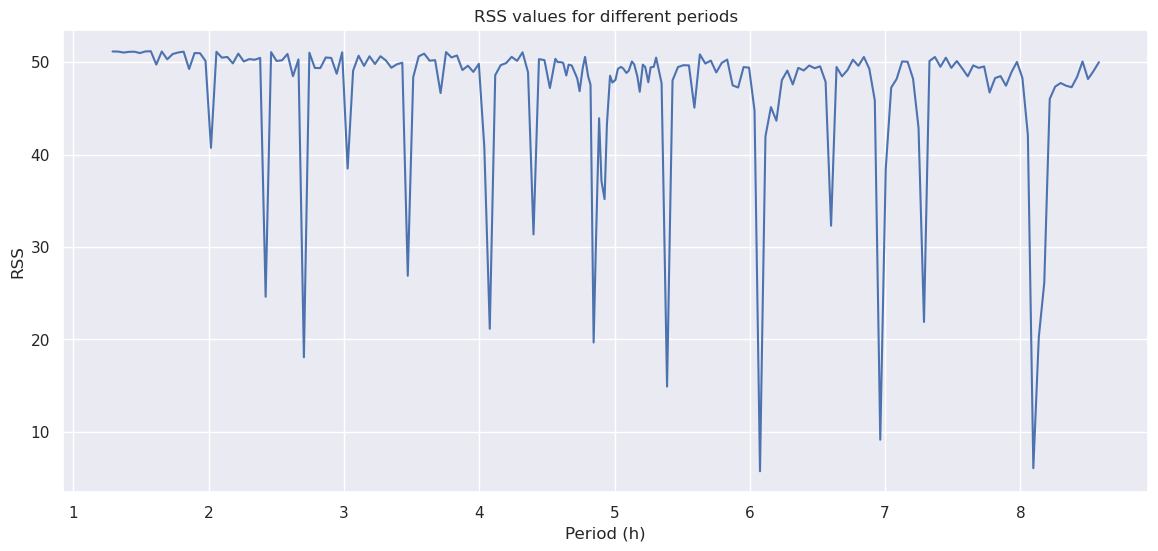

RSS values range: 5.743286 - 51.171359, threshold: 6.814211
Selected periods: [6.075269489866777, 6.964158378755666, 8.095471510068798]

Best RSS value: 2.226360 found for period: 6.082677h
Compared to the known period: 6.082754h (diff: 0.000077h)


In [28]:
period_range = sorted(
    [lomb_period + i for i in np.linspace(-2, 2, 100)] + [2 * lomb_period + i for i in np.linspace(-2, 2, 100)]
)

rss_values = get_rrs_values(period_range)

plt.plot(period_range, rss_values)
plt.title("RSS values for different periods")
plt.xlabel("Period (h)")
plt.ylabel("RSS")
plt.show()

# Select the period with the lowest RSS as well as ones close to the lowest RSS
min_rss = np.min(rss_values)
max_rss = np.max(rss_values)
threshold = 0.15 * (max_rss - min_rss)
print(f"RSS values range: {min_rss:.6f} - {max_rss:.6f}, threshold: {threshold:.6f}")

selected_periods = []
for period, rss in zip(period_range, rss_values):
    if rss < min_rss + threshold:
        selected_periods.append(period)

print(f"Selected periods: {selected_periods}\n")

filtered_periods = []
filtered_rss = []
for period in selected_periods:
    period_range = np.linspace(period - 0.2, period + 0.2, 1000)
    rss_values = get_rrs_values(period_range)

    lowest_ind = np.argmin(rss_values)
    filtered_rss.append(rss_values[lowest_ind])
    filtered_periods.append(period_range[lowest_ind])

best_rss_ind = np.argmin(filtered_rss)

best_period = filtered_periods[best_rss_ind]
best_rss = filtered_rss[best_rss_ind]

print(f"Best RSS value: {best_rss:.6f} found for period: {best_period:.6f}h")
print(f"Compared to the known period: {known_period:.6f}h (diff: {C_Y_S}{abs(known_period - best_period):.6f}h{C_E})")

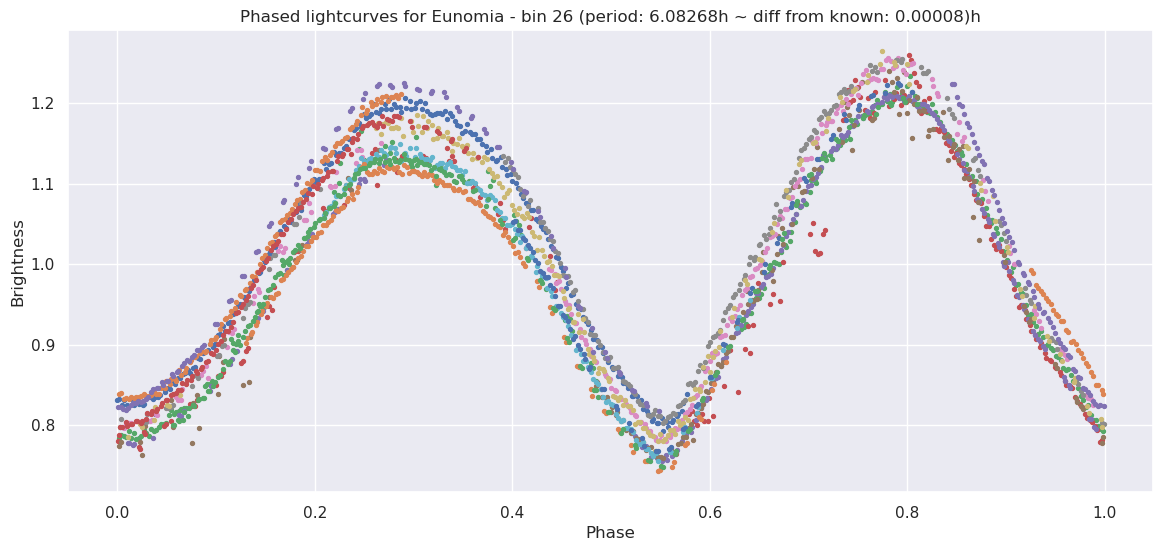

In [29]:
def plot_phased_lightcurves(selected_bin: list[Lightcurve], period: float):
    ref_JD = None
    for lc in selected_bin:
        if ref_JD is None:
            ref_JD = lc.first_JD

        phases = []
        brightness = []
        for point in lc.points:

            phase = get_phase(point.JD, ref_JD, period)

            phases.append(phase)
            brightness.append(point.brightness)

        plt.scatter(phases, brightness, s=8, label=f"Lightcurve {lc.id}")


    plt.title(f"Phased lightcurves for {asteroid_name} - bin {SELECTED_BIN} (period: {period:.5f}h ~ diff from known: {abs(known_period - period):.5f})h")
    plt.xlabel("Phase")
    plt.ylabel("Brightness")
    plt.show()


plot_phased_lightcurves(selected_bin, best_period)


In [30]:
raise

RuntimeError: No active exception to reraise

In [ ]:
if False:
    # Grid search for the best period
    for inc in np.linspace(-0.1, 0.1):
        ref_JD = None
        period = best_period * 2 + inc
        print(f"Trying period: {period:.6f}h")
        for ind, lc in enumerate(selected_bin):
            if ref_JD is None:
                ref_JD = lc.first_JD

            phases = []
            brightness = []
            for point in lc.points:
                phase = get_phase(point.JD, ref_JD, period)

                phases.append(phase)
                brightness.append(point.brightness)

            plt.scatter(phases, brightness, s=8, label=f"Lightcurve {lc.id}")


        plt.title(f"Phased lightcurves for {asteroid_name} - bin {SELECTED_BIN}")
        plt.xlabel("Phase")
        plt.ylabel("Brightness")
        # plt.legend()
        plt.show()